In [8]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

import warnings
warnings.simplefilter(action='ignore')

In [9]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

## По скважине

In [10]:
df = pd.read_excel("data/тсз1.xlsx")

[ 0.          0.51724138  1.03448276  1.55172414  2.06896552  2.5862069
  3.10344828  3.62068966  4.13793103  4.65517241  5.17241379  5.68965517
  6.20689655  6.72413793  7.24137931  7.75862069  8.27586207  8.79310345
  9.31034483  9.82758621 10.34482759 10.86206897 11.37931034 11.89655172
 12.4137931  12.93103448 13.44827586 13.96551724 14.48275862 15.        ]


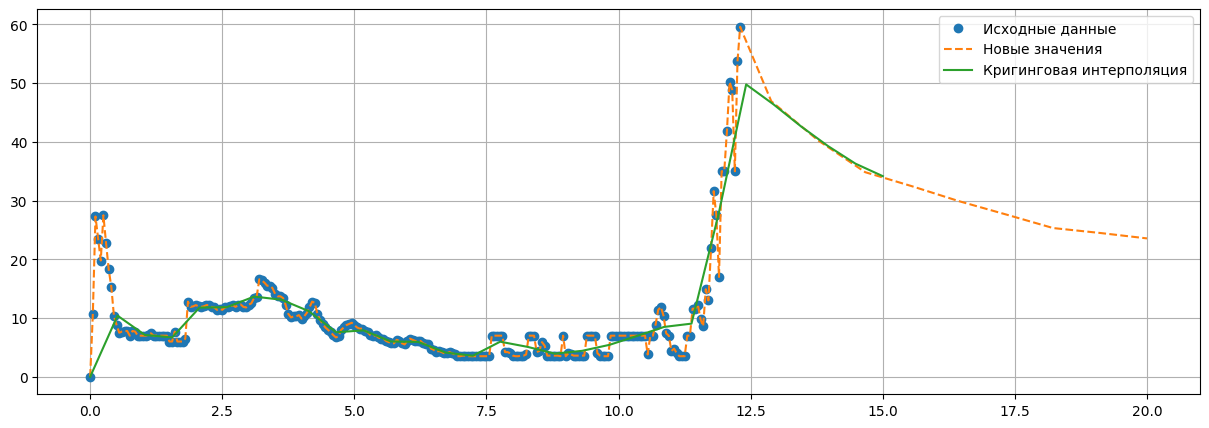

In [11]:
x = df["h"].to_numpy()
y = df["E"].to_numpy()
model = 'exponential'

x_list = np.array([0.075+i for i in range(15)])#np.linspace(1, 12, 10)
x_list = np.linspace(12, 20, 10)
random.shuffle(x_list)

for x_now in x_list:
    
    OK = OrdinaryKriging(x, np.zeros_like(x), y, variogram_model=model)

    y_now, ss = OK.execute('grid', x_now, np.zeros_like(x_now))
    
    x = np.append(x, x_now)
    y = np.append(y, y_now)

    # Построение графика


    
x_new = np.linspace(0, 15, 30)
OK = OrdinaryKriging(x, np.zeros_like(x), y, variogram_model=model)
y_new, ss = OK.execute('grid', x_new, np.zeros_like(x_now))

df_now = pd.DataFrame({"x":x, "y":y})
df_now = df_now.sort_values(by="x")


print(x_new)

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(df["h"], df["E"], 'o', label='Исходные данные')
plt.plot(df_now["x"], df_now["y"], '--', label='Новые значения')
plt.plot(x_new, y_new[0,:], '-', label='Кригинговая интерполяция')
plt.legend()
plt.show()

## В плане

In [12]:
df_boreholes = df_boreholes = pd.read_excel(f"data/координаты_скважин.xlsx")
#house_3 = df_boreholes[(df_boreholes["тсз"]>50) & (df_boreholes["тсз"]!=148)].reset_index(drop= True) # точки от 50, кроме 148
house_3 = pd.read_excel("data/house_3_local.xlsx")

In [13]:
all_E = pd.DataFrame(columns=["borehole", "x", "y", "z", "h", "E"])

for borehole in house_3["тсз"]:
    borehole_info = house_3[house_3["тсз"]==borehole]
    df_now = pd.read_excel(f"data/тсз{borehole}.xlsx")
    df_now = get_filter_df(df_now, "E").loc[:, ["h", "E"]]
    
    df_now["borehole"] = borehole 
    df_now["x"] = borehole_info["x"].iloc[0]
    df_now["y"] = borehole_info["y"].iloc[0]
    df_now["z"] = borehole_info["z"].iloc[0]

    all_E = pd.concat([all_E, df_now], ignore_index=True)

all_E["z_h"] = all_E["z"] - all_E["h"]
print(all_E.head(), all_E.shape)

  borehole             x            y       z     h    E     z_h
0       51  97607.570697  4338.997129  76.631  0.00  0.0  76.631
1       51  97607.570697  4338.997129  76.631  0.05  6.0  76.581
2       51  97607.570697  4338.997129  76.631  0.10  6.0  76.531
3       51  97607.570697  4338.997129  76.631  0.15  6.0  76.481
4       51  97607.570697  4338.997129  76.631  0.20  6.0  76.431 (24429, 7)


In [14]:
all_E["group"] = all_E["z_h"]//1
group_E = all_E.groupby(by=["group", "borehole"]).mean()
group_E["group"] = [int(x[0]) for x in group_E.index]
group_E["borehole"] = [int(x[1]) for x in group_E.index]

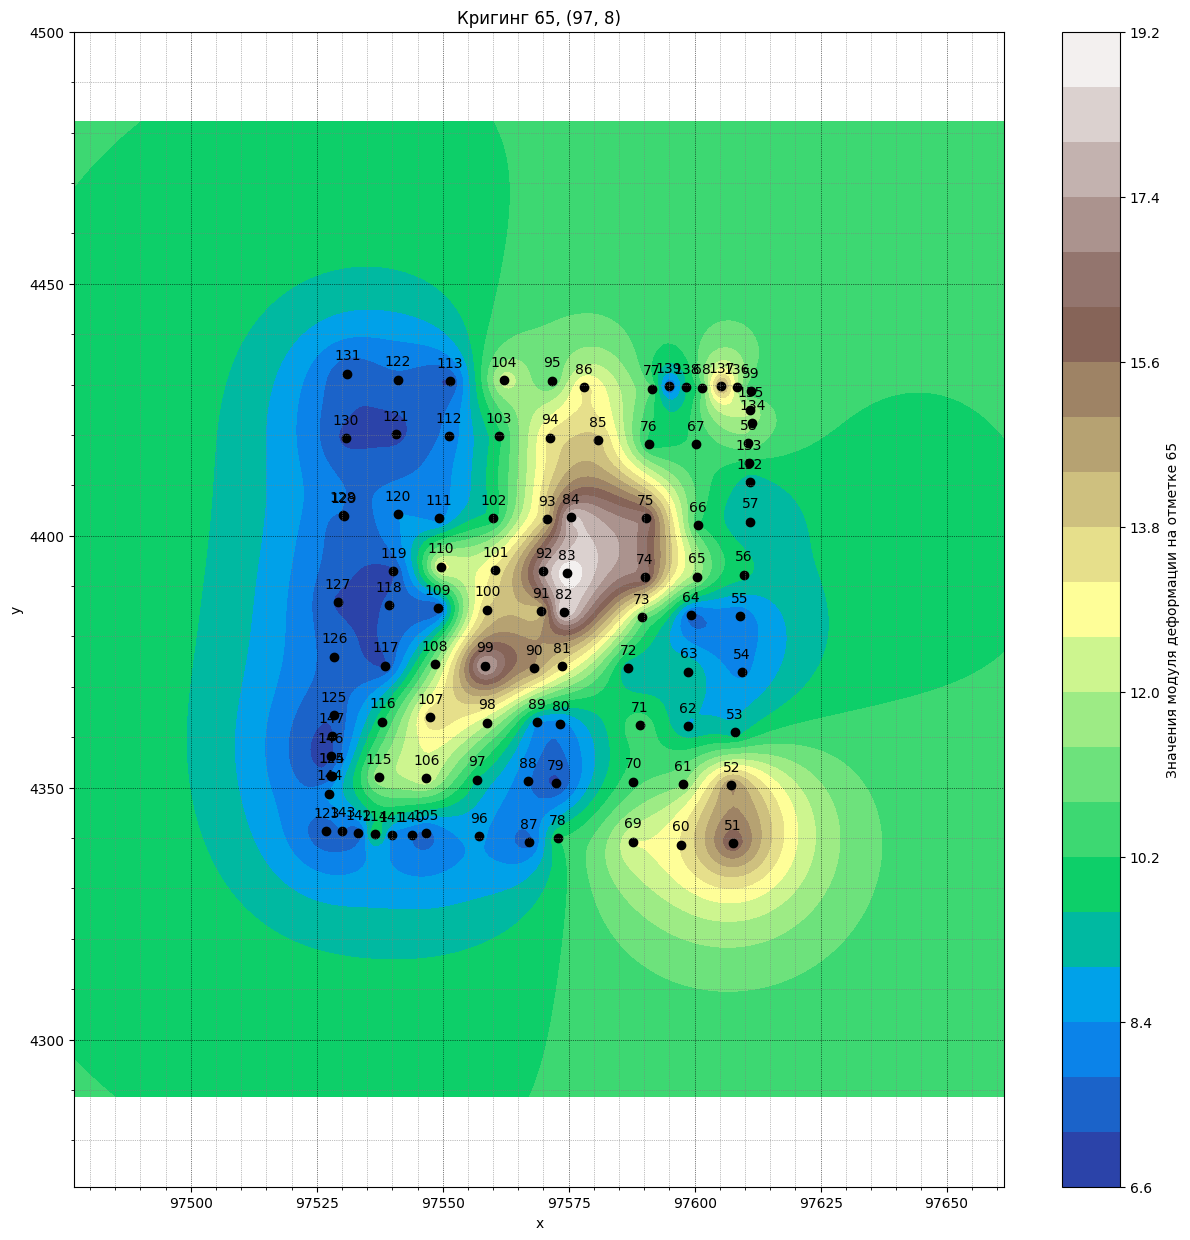

In [15]:
model = 'exponential'


for g in [65]:#group_E["group"].unique():
    df_now = group_E.query('group == @g')

    x = df_now["x"].to_numpy()
    y = df_now["y"].to_numpy()
    E = df_now["E"].to_numpy()
    labels = df_now["borehole"].to_numpy()#df_now["E"].apply(int).to_numpy()

    OK = UniversalKriging(x, 
                         y, 
                         E, 
                         variogram_model=model
                        )
    
    x_new = np.linspace(np.min(x)-50, np.max(x)+50, 200)
    y_new = np.linspace(np.min(y)-50, np.max(y)+50, 200)
    
    z_new, variance = OK.execute('grid', x_new, y_new)
    
    X, Y = np.meshgrid(x_new, y_new)
    
    
    plt.figure(figsize=(15, 15))
    # Добавляем основную сетку
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    # Добавляем дополнительную сетку
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # Включаем дополнительные деления на осях
    plt.minorticks_on()
    # Сохранение пропорций X Y
    plt.axis('equal')
    
    plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
    cbar = plt.colorbar()
    cbar.set_label(f'Значения модуля деформации на отметке {g}')
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color="k")
        plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
    
    plt.title(f'Кригинг {g}, {df_now.shape}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

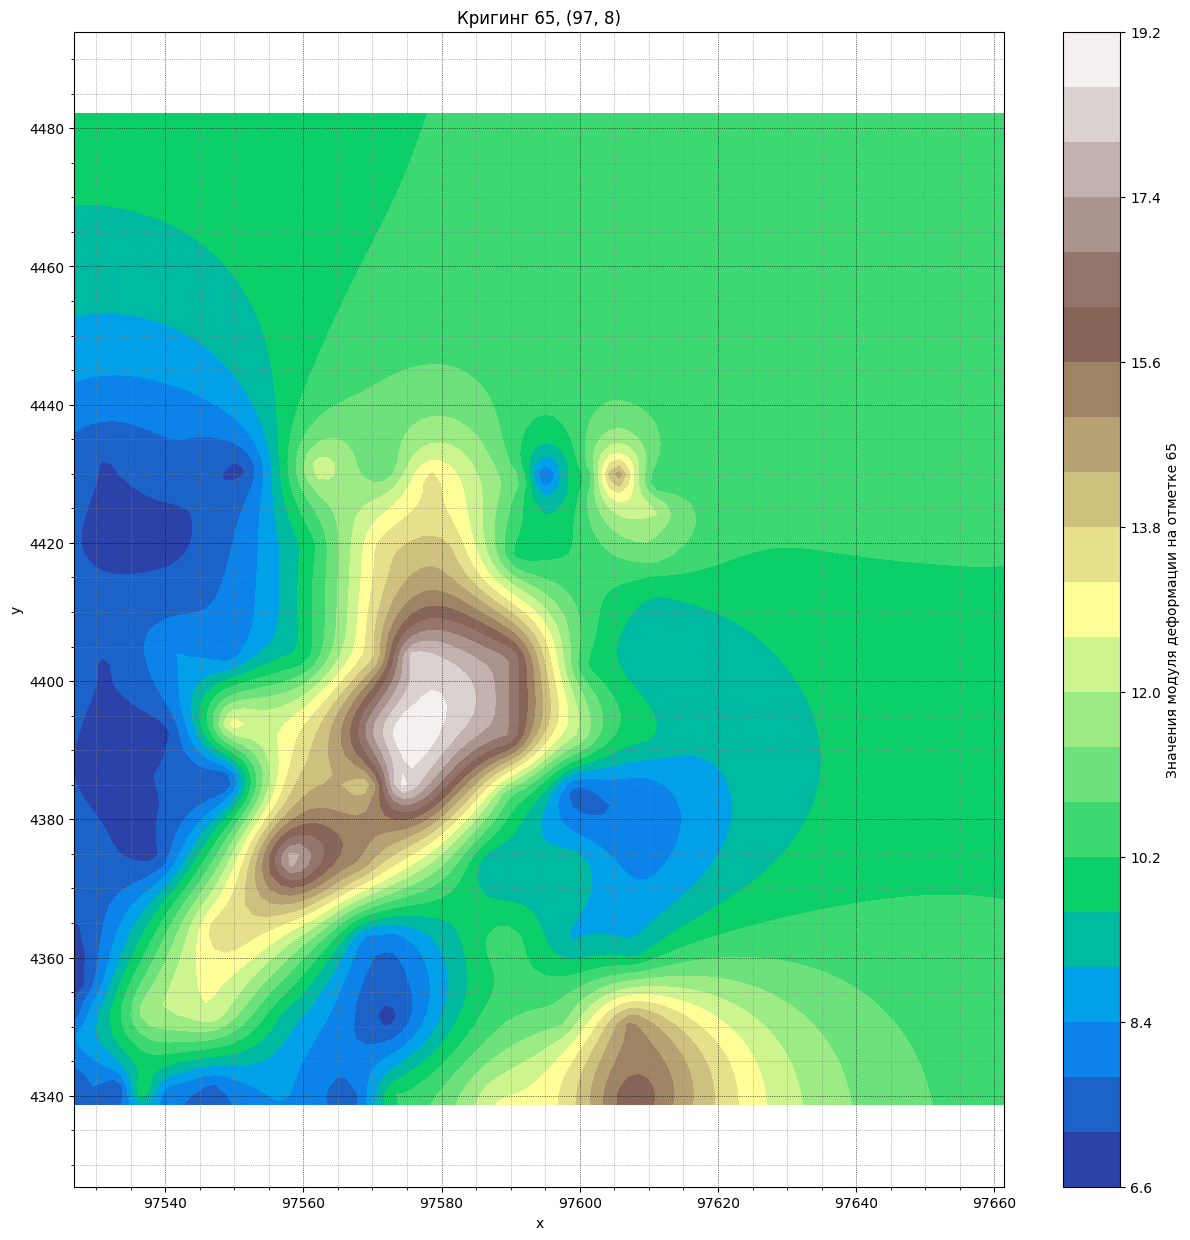

In [16]:
x_list = np.linspace(np.max(x)-3, np.max(x)+50, 10)
y_list = np.linspace(np.max(y)-3, np.max(y)+50, 10)

model = 'exponential'
x = df_now["x"].to_numpy()
y = df_now["y"].to_numpy()
E = df_now["E"].to_numpy()


df_now = group_E.query('group == 65')

random.shuffle(x_list)
for x_now in x_list:
    random.shuffle(y_list)
    for y_now in y_list:
        OK = UniversalKriging(x, y, E, variogram_model=model)
        z_now, ss = OK.execute('points', x_now, y_now)
        x = np.append(x, x_now)
        y = np.append(y, y_now)
        E = np.append(E, z_now)


OK = UniversalKriging(x, 
                         y, 
                         E, 
                         variogram_model=model
                        )
    
x_new = np.linspace(np.min(x), np.max(x), 100)
y_new = np.linspace(np.min(y), np.max(y), 100)
    
z_new, variance = OK.execute('grid', x_new, y_new)
    
X, Y = np.meshgrid(x_new, y_new)
    
    
plt.figure(figsize=(15, 15))
# Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    # Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # Включаем дополнительные деления на осях
plt.minorticks_on()
# Сохранение пропорций X Y
plt.axis('equal')    
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке {g}')
    
    
plt.title(f'Кригинг {g}, {df_now.shape}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Регресс. кригинг (стохастический)

In [17]:
df_now = group_E.query('group == 65')


In [18]:
svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(copy_X=True, fit_intercept=False)


try:
    housing = fetch_california_housing()
except PermissionError:
    # this dataset can occasionally fail to download on Windows
    sys.exit(0)

# take the first 5000 as Kriging is memory intensive
p = df_now.loc[:, ["x", "y"]].to_numpy()
x = df_now.loc[:, ["x", "y"]].to_numpy()
target = df_now["E"].to_numpy()

p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    p, x, target, test_size=0.3, random_state=123
)

In [19]:
p.shape, x.shape, target.shape

((97, 2), (97, 2), (97,))

In [20]:
models = [svr_model, rf_model, lr_model]
name_models = ["SVR", "RF", "LR"]
dict_models = {}

for i in range(len(models)):
    m = models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10, variogram_model='exponential')
    m_rk.fit(p_train, x_train, target_train)
    dict_models[name] = m_rk
    print("Regression Score: ", m_rk.regression_model.score(p_test, target_test))
    print("RK score: ", m_rk.score(p_test, x_test, target_test))

regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.19531616946657793
RK score:  0.5813418666308987
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.4128274752463068
RK score:  0.44890775369069347
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.08456997797682408
RK score:  0.5849118321920401


Finished learning regression model
Finished kriging residuals


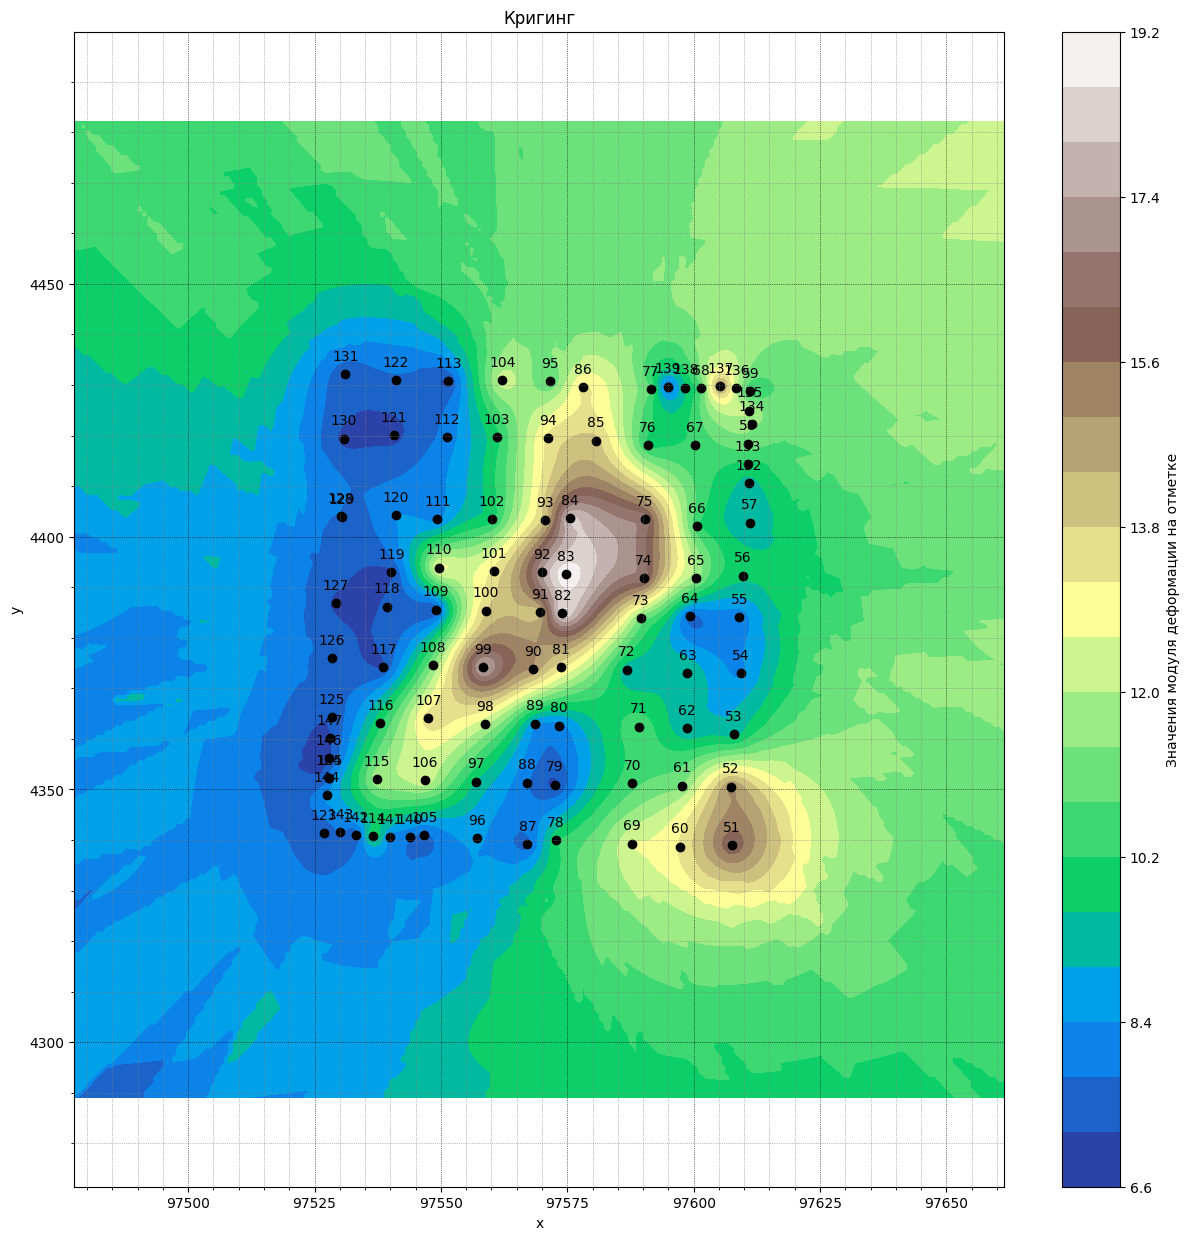

In [36]:
m_rk = RegressionKriging(regression_model=lr_model, n_closest_points=30, variogram_model='exponential')
m_rk.fit(p, x, target)
size = (200, 200)

x_new = np.linspace(np.min(x_train[:, 0])-50, np.max(x_train[:, 0])+50, size[0])
y_new = np.linspace(np.min(x_train[:, 1])-50, np.max(x_train[:, 1])+50, size[1])
X, Y = np.meshgrid(x_new, y_new)

data = np.array([X.reshape(-1), Y.reshape(-1)]).T

z_new = np.reshape(m_rk.predict(data, data), (size[0], size[1]))


plt.figure(figsize=(15, 15))
# Добавляем основную сетку
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    # Добавляем дополнительную сетку
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # Включаем дополнительные деления на осях
plt.minorticks_on()
# Сохранение пропорций X Y
plt.axis('equal')    
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке')

points_x = df_now["x"].to_numpy()
points_y = df_now["y"].to_numpy()
labels = df_now["borehole"].to_numpy()
for i in range(len(points_x)):
    plt.scatter(points_x[i], points_y[i], color="k")
    plt.annotate(labels[i], (points_x[i], points_y[i]), textcoords="offset points", xytext=(0,10), ha='center')


    
plt.title(f'Кригинг')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Оптимальные параметры: наггет = -0.18012842568502108 , порог = 3.578050119694598 , фактический ранг = 2.495274673760923


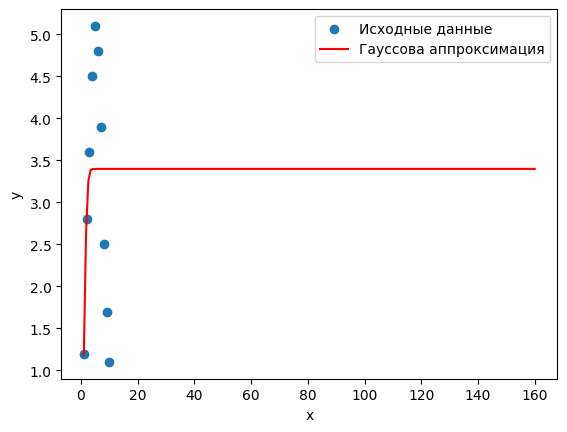

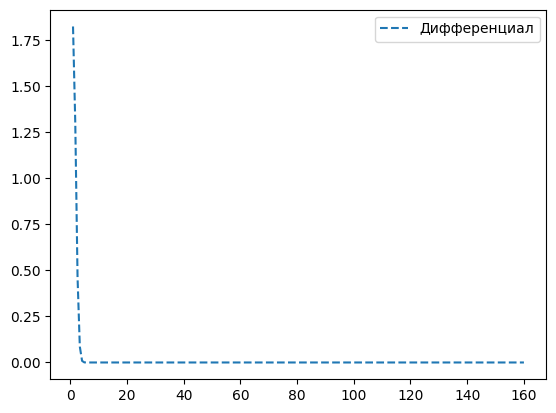

In [23]:
# Пример данных
x_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])


def gaussian(h, nugget, sill, rang):
    return nugget + sill * (1 - np.exp(-3*(h / rang)**2))


# Аппроксимация данных
popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 5, 1])

# Оптимальные параметры
a_opt, b_opt, c_opt = popt
print("Оптимальные параметры: наггет =", a_opt, ", порог =", b_opt, ", фактический ранг =", c_opt)

# Построение исходных данных и аппроксимированной функции
x_fit = np.linspace(min(x_data), max(x_data) + 150, 200)
y_fit = gaussian(x_fit, *popt)

plt.scatter(x_data, y_data, label='Исходные данные')
plt.plot(x_fit, y_fit, label='Гауссова аппроксимация', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


dy_dx = np.gradient(y_fit, x_fit)
plt.plot(x_fit, dy_dx, label='Дифференциал', linestyle='--')
plt.legend()
plt.show()

-22.15785668307292 -36.59969361091157 -1.4170678293528327 11317.265621582173 4084.704191712946


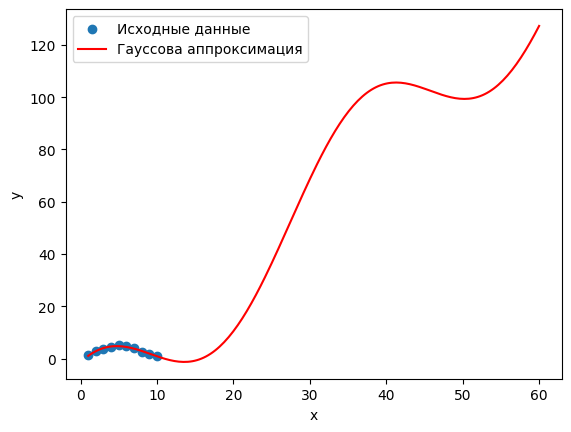

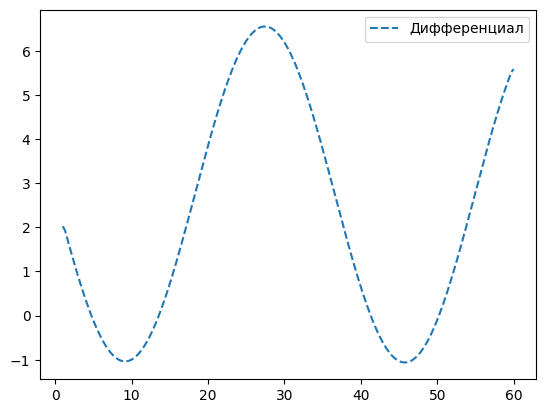

In [24]:
# Пример данных
x_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])


def gaussian(h, nugget, sill, rang):
    return nugget + sill * (1 - np.exp(-3*(h / rang)**2))


def var_func(h, D1, Df, al, af, w):
    return D1*np.exp(-al*h)*np.cos(w*h)+Df*np.exp(-af*h)


def vario_func(h, amplitude=1.0, period=2.0, nugget=0.0, sill=1.0, range_=10.0):
    """
    Periodic variogram function.

    Parameters
    ----------
    h : array_like
        Separation distances.
    amplitude : float, optional
        Amplitude of the periodic component. Default is 1.0.
    period : float, optional
        Period of the periodic component. Default is 2.0.
    nugget : float, optional
        Nugget term. Default is 0.0.
    sill : float, optional
        Sill term. Default is 1.0.
    range_ : float, optional
        Range term. Default is 10.0.
    Returns
    -------
    numpy.ndarray
        Computed variogram values.

    """
    h = np.abs(h)
    periodic = amplitude * (1 - np.cos(2 * np.pi * h / period))
    variogram = nugget + sill * (1 - np.exp(-h / range_)) + periodic

    return variogram



# Аппроксимация данных
popt, pcov = curve_fit(vario_func, x_data, y_data)

# Оптимальные параметры
D1, Df, al, af, w = popt
print(D1, Df, al, af, w)

# Построение исходных данных и аппроксимированной функции
x_fit = np.linspace(min(x_data), max(x_data) + 50, 200)
y_fit = vario_func(x_fit, *popt)

plt.scatter(x_data, y_data, label='Исходные данные')
plt.plot(x_fit, y_fit, label='Гауссова аппроксимация', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


dy_dx = np.gradient(y_fit, x_fit)
plt.plot(x_fit, dy_dx, label='Дифференциал', linestyle='--')
plt.legend()
plt.show()

## Ошибочные

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from gstools import GaussianModel, RegressionModel, krige

# Generate some random data
np.random.seed(0)
x = np.random.uniform(0, 10, 50)
y = np.random.uniform(0, 10, 50)
z = np.sin(x / 2) + np.cos(y / 2) + np.random.normal(0, 0.2, 50)

# Define the regression model
reg_model = RegressionModel(model='linear', variables=[x, y])

# Define the Gaussian model
gauss_model = GaussianModel(dim=2, var=1, len_scale=1.5, nugget=0.1)

# Perform regression-kriging
kriged = krige(points=np.array([x, y]).T, values=z, reg_model=reg_model,
                gauss_model=gauss_model, verbose=0)

# Plot the results
X, Y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
Z = reg_model.predict(np.array([X.flatten(), Y.flatten()])).reshape(X.shape)
Z_kriged = kriged.predict(np.array([X, Y]).T).reshape(X.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].contourf(X, Y, Z, cmap='viridis')
axs[0].scatter(x, y, c=z, cmap='viridis')
axs[0].set_title('Regression model')

axs[1].contourf(X, Y, Z_kriged, cmap='viridis')
axs[1].scatter(x, y, c=z, cmap='viridis')
axs[1].set_title('Regression-kriging model')

plt.show()


ModuleNotFoundError: No module named 'gstools'